In [1]:
import json
import random  # For sampling
import datetime as dt
from time import sleep

import pandas as pd
import seaborn as sns  # Standard visualisations
from matplotlib import pyplot
from socket import timeout  # Using timeout error for exceptions on geohash
import swifter  # For easy parallelization of panda applys
from tqdm import tqdm_notebook as tqdm

import geohash  # To decode Geohashes
from geopy.geocoders import Nominatim  # To convert lat/long to addresses
from geopy.distance import distance  # For distance between two coordinates

geolocator = Nominatim(user_agent="hQ0PeXSNGppwoFjrtOUhJW95G5URrD8p")

d:\google drive\audienceserv\jupyter\venv\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
df_train = pd.read_csv('d:/Google Drive/dev/Grab/Traffic Management/training.csv')

In [37]:
df_train.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


In [9]:
df_train.day.max()

61

In [10]:
df_train.iloc[0].day

18

In [11]:
# How many Locations are we dealing with
len(df_train.geohash6.unique())

1329

In [12]:
df_train[df_train.geohash6 == 'qp090w'].demand.max()

0.12709240888955772

Fidings about the data set to this point:
  - Demand is aggregated over the entire dataset, not the region
  - There is no directly obvious pattern regarding weekdays
  - Many time values are missing
  - For same lovations, he demand is relativly steady on a day-sto-day basis

In [6]:
# Creating a datetime dummy, since no information about the real date is given,
# we simply assume that day 1 is the 1st of March, while ignoring all the other things 
# that would normally come with that date (weekday, holidays etc.)
def combine_datetime(row):
    # Initialise the date with the time
    date = dt.datetime.strptime(row.timestamp, '%H:%M')
    if row.day <= 31:
        month = 3
        day = row.day
    else:
        month = 4
        day = row.day - 31
    date = date.replace(year=2019, month=month, day=day)
    
    return date

df_train['datetime'] = df_train.apply(lambda row: combine_datetime(row), axis=1)

# We can append the missing datetime vaules by comparing the existing ones for each
# geo-location with a date_range
missing_rows = list()
for ghash in tqdm(df_train.geohash6.unique()):
    missing_dates = pd.date_range(start=dt.date(2019, 3, 1), 
                                  end=dt.datetime(2019, 4, 30, 23, 45, 0), 
                                  freq='15min')\
                      .difference(df_train[df_train.geohash6 == 'qp02yy'].datetime)
  
    for date in missing_dates:
        day = abs((date - dt.datetime(2019, 3, 1, 0, 0)).days) + 1
        missing_rows.append({'geohash6': ghash, 
                             'day': day, 
                             'timestamp': date.strftime('%H:%M'), 
                             'demand': 0,
                             'datetime': date})

# Combine the dataset with the missing rows
df_train = pd.concat([df_train, pd.DataFrame(missing_rows)])

d:\google drive\audienceserv\jupyter\venv\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [7]:
df_train.to_csv('20190613_Grab_train_filled.csv', index=False)

In [8]:
lend(df_train)

NameError: name 'lend' is not defined

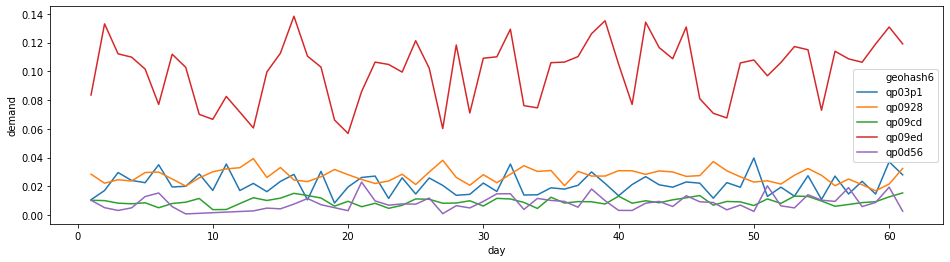

In [90]:
# Plot traffic over time for 5 random locations on a day basis
sample_locs = random.sample(list(df_train.geohash6.unique()), 5)
df_sample = df_train[df_train.geohash6.isin(sample_locs)]

df_sample = df_sample.groupby(['geohash6', 'day']).median().reset_index()

fig, ax = pyplot.subplots(figsize=(16,4))
sns.lineplot(data=df_sample, x='day', y='demand', hue='geohash6', ax=ax)

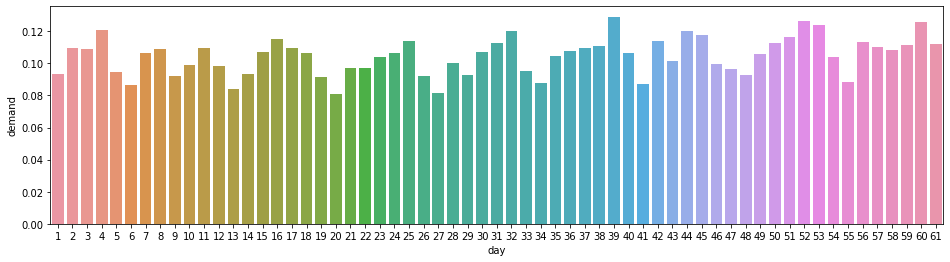

In [34]:
# Plot demand over all geo locations (mean)
df_sample = df_train.groupby(['day']).mean().reset_index()

fig, ax = pyplot.subplots(figsize=(16,4))
sns.barplot(data=df_sample, x='day', y='demand', ax=ax)

d:\google drive\audienceserv\jupyter\venv\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



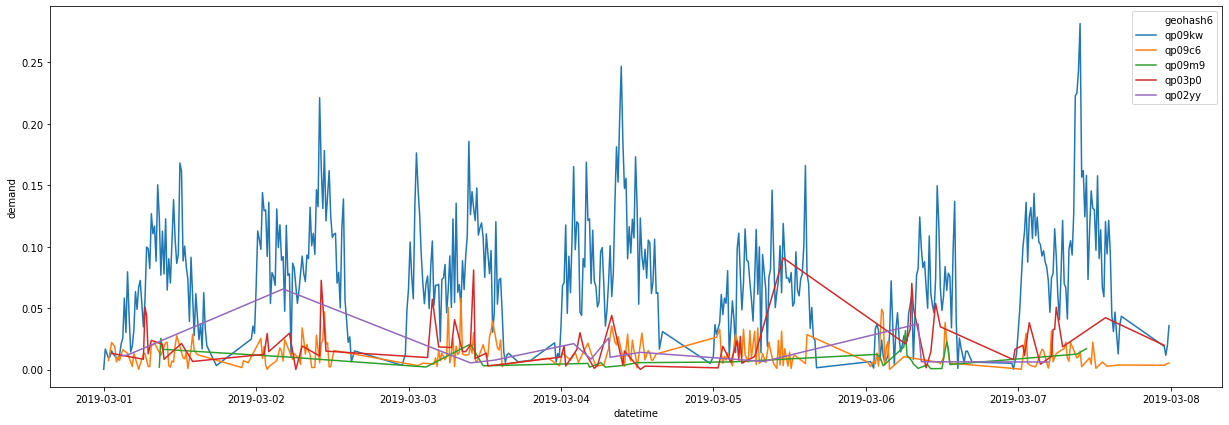

In [121]:
# Plot traffic over time for 5 random locations for the first 14 days for all data
sample_locs = random.sample(list(df_train.geohash6.unique()), 5)
df_sample = df_train[df_train.geohash6.isin(sample_locs) & (df_train.day <= 7)]

# Creating a datetime dummy, since no information about the real date is given,
# we simply assume that day 1 is the 1st of March, while ignoring all the other things 
# that would normally come with that date (weekday, holidays etc.)
def combine_datetime(row):
    # Initialise the date with the time
    date = dt.datetime.strptime(row.timestamp, '%H:%M')
    if row.day <= 31:
        month = 3
        day = row.day
    else:
        month = 4
        day = row.day - 31
    date = date.replace(year=2019, month=month, day=day)
    
    return date

df_sample['datetime'] = df_sample.apply(lambda row: combine_datetime(row), axis=1)

fig, ax = pyplot.subplots(figsize=(21,7))
sns.lineplot(data=df_sample, x='datetime', y='demand', hue='geohash6', ax=ax)

In [27]:
# For performance increase, avoid looking up the same value multiple times
GEO_CACHE = {}

In [28]:
def get_geo_location(lat, lon):
    """Geolocator times our every few hundred calls. Waiting for a min fixes the issue"""
    try:
        location = geolocator.reverse(f'{lat}, {lon}')
    except timeout:
        sleep(60)
        location = get_geo_location(ghash)
    return location
    

def get_geo_information(ghash):
    if not (ghash in GEO_CACHE):
        # Convert the geohash into 
        lat, lon = geohash.decode(ghash)
        
        # Getting the address via Nominatim
        # location = get_geo_location(lat, lon)
        #
        # During testing, some locations were in the middle of the ocean, leading to the geolocator to return an error
        # {'error': 'Unable to geocode'}
        # We find that the lo
        # if 'error' in location.raw:
        #    geo_info = {'lat': lat, 'lon': lon} 
        # else:
        #    geo_info = location.raw

        geo_info = {'lat': lat, 'lon': lon}
        GEO_CACHE[ghash] = geo_info
    
    return GEO_CACHE[ghash]
     
# Load all geo information
for ghash in tqdm(df_train.geohash6.unique()):
    _ = get_geo_information(ghash)
    
# For future reference and usage, save the information locally as json
json.dump(GEO_CACHE, open("20190612_GrabChallenge_GeoData.json",'w'))

In [29]:
GEO_CACHE

{'qp03wc': {'lat': -5.35308837890625, 'lon': 90.6536865234375},
 'qp03pn': {'lat': -5.41351318359375, 'lon': 90.6646728515625},
 'qp09sw': {'lat': -5.32562255859375, 'lon': 90.9063720703125},
 'qp0991': {'lat': -5.35308837890625, 'lon': 90.7525634765625},
 'qp090q': {'lat': -5.41351318359375, 'lon': 90.7196044921875},
 'qp03tu': {'lat': -5.33660888671875, 'lon': 90.6097412109375},
 'qp096d': {'lat': -5.39154052734375, 'lon': 90.8184814453125},
 'qp03nr': {'lat': -5.40802001953125, 'lon': 90.6317138671875},
 'qp093r': {'lat': -5.36407470703125, 'lon': 90.7635498046875},
 'qp03r2': {'lat': -5.40252685546875, 'lon': 90.6756591796875},
 'qp09kb': {'lat': -5.40252685546875, 'lon': 90.9173583984375},
 'qp03rp': {'lat': -5.36407470703125, 'lon': 90.6646728515625},
 'qp03w9': {'lat': -5.35308837890625, 'lon': 90.6427001953125},
 'qp096m': {'lat': -5.37506103515625, 'lon': 90.8074951171875},
 'qp091u': {'lat': -5.42449951171875, 'lon': 90.7855224609375},
 'qp03md': {'lat': -5.39154052734375, 'l

### Result
Unfortunately, all given locations are located somewhere in the Indian Ocean, making it impossible to append any useful locaiton-based information, i.e. weather, weather forcaste, "Popular Times" information of surrounding places etc.

In [28]:
lat

-5.41351318359375

In [32]:
location = geolocator.reverse("52.509669, 13.37624294")
location.raw

{'place_id': 198746248,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'relation',
 'osm_id': 3200536,
 'lat': '52.5098014',
 'lon': '13.3755897912911',
 'display_name': 'Potsdamer Platz, Tiergarten, Mitte, Berlin, 10785, Deutschland',
 'address': {'attraction': 'Potsdamer Platz',
  'footway': 'Potsdamer Platz',
  'suburb': 'Tiergarten',
  'city_district': 'Mitte',
  'city': 'Berlin',
  'postcode': '10785',
  'country': 'Deutschland',
  'country_code': 'de'},
 'boundingbox': ['52.5082999', '52.5100374', '13.3750548', '13.3769528']}

In [31]:
location = geolocator.reverse("-5.41351318359375, 90.6646728515625")
location.raw

{'error': 'Unable to geocode'}

In [21]:
str(geohash.decode('qp03pn'))[1:-1]

'-5.41351318359375, 90.6646728515625'